#### Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of **79 variables** describing many aspects of residential homes in *Ames, Iowa.* Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: House Prices

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

    Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

    Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
    Investigate the data, and do any necessary data cleaning.
    Explore the data and find some variables that you think would be useful in predicting house prices.
    Build your initial model using these features and estimate the parameters using OLS.

Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at this example solution.


data source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

houseprices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


##### Investigate the data, and do any necessary data cleaning.

In [4]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
houseprices_df.isnull().sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
                 ... 
bedroomabvgr        0
kitchenabvgr        0
kitchenqual         0
totrmsabvgrd        0
functional          0
fireplaces          0
fireplacequ       690
garagetype         81
garageyrblt        81
garagefinish       81
garagecars          0
garagearea          0
garagequal         81
garagecond         81
paveddrive

##### will look at correlation of features with target before deciding what to do with missing values

In [30]:
houseprices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


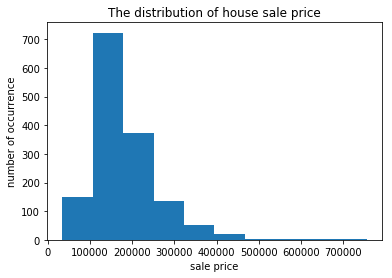

In [29]:
plt.hist(houseprices_df.saleprice)
plt.title('The distribution of house sale price')
plt.xlabel('sale price')
plt.ylabel('number of occurrence')
plt.show()

Sales price is not normally distributed; the majority of the values fall between approx $50K and $400K with a skew to the right. 

##### Explore the data and find some variables that you think would be useful in predicting house prices.

In [49]:
#look at correlation of each potential feature with target
#start with numerical features which don't require conversion
numerics = houseprices_df.select_dtypes(include=[np.number])
numerics.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [45]:
numerics.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
bsmtfinsf1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


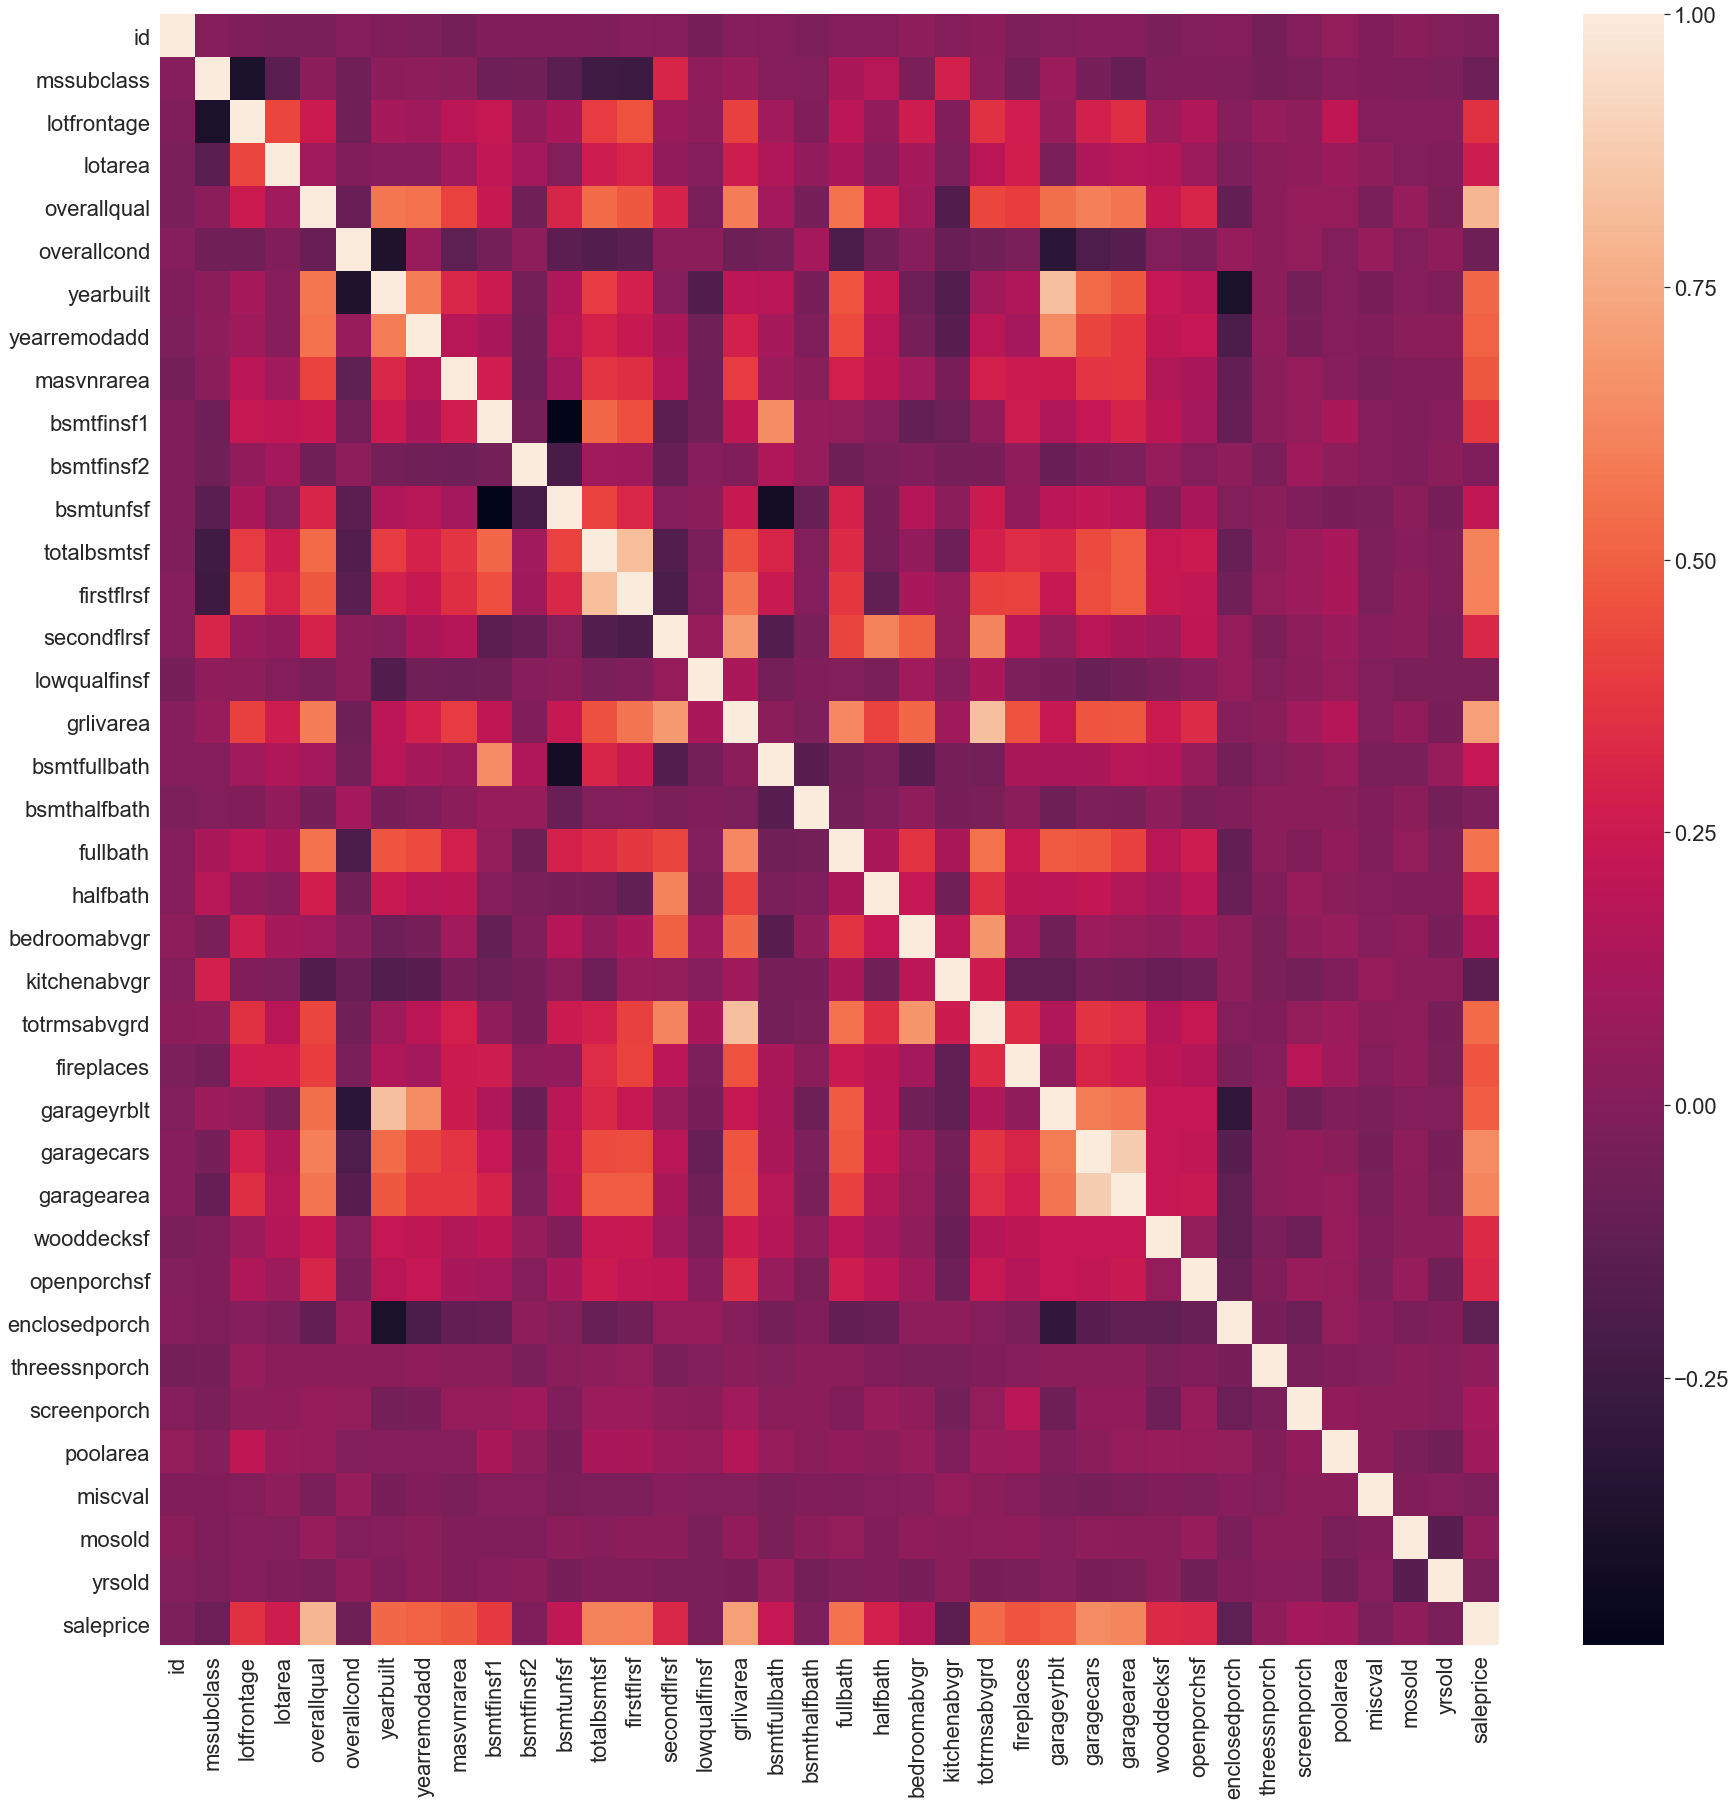

In [48]:
import seaborn as sns
plt.figure(figsize=(30,30))
sns.set(font_scale=2)
sns.heatmap(numerics.corr())

In [55]:
#from sample answer, doesn't work
np.abs(houseprices_df[numerics].iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

ValueError: Must pass DataFrame with boolean values only

###### find a way to make sample answer work!
the list would be easier to read than heatmap and correlation grid

In [60]:
#potential features from numeric columns: 
num_features = ['overallqual', 'totalbsmtsf', 
                'firstflrsf', 'grlivarea', 'fullbath', 
                'garagecars', 'garagearea', 'yearbuilt', 
                'yearremodadd', 'masvnrtype', 'totrmsabvgrd', 
                'fireplaces', 'garageyrblt']

In [61]:
houseprices_df[num_features].isnull().sum()

overallqual      0
totalbsmtsf      0
firstflrsf       0
grlivarea        0
fullbath         0
garagecars       0
garagearea       0
yearbuilt        0
yearremodadd     0
masvnrtype       8
totrmsabvgrd     0
fireplaces       0
garageyrblt     81
dtype: int64

'garageyrblt' had a lower correlation with the sales price, will delete from the list of potential features

In [ ]:
num2_features = ['overallqual', 'totalbsmtsf', 
                'firstflrsf', 'grlivarea', 'fullbath', 
                'garagecars', 'garagearea', 'yearbuilt', 
                'yearremodadd', 'masvnrtype', 'totrmsabvgrd', 
                'fireplaces']

###### non-numerical features

In [53]:
objects = houseprices_df.select_dtypes(include=[np.object])
objects.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


###### categorical values = 
'neighborhood', string values (20)#this is probably important
'bsmtcond', string values (6)-rank into 2?
'heatingqc', string values (5)-rank into 2?
'centralair', string, yes/no
'kitchenqual', string values (5)-rank into 2 
'paveddrive', string values (3)-rank into 3? 

categorical values represented by numbers = 
'mssubclass', categories represented by integers
'overallcond', categories represented by integers

In [62]:
houseprices_df['central_air'] = pd.get_dummies(houseprices_df.centralair, drop_first=True)

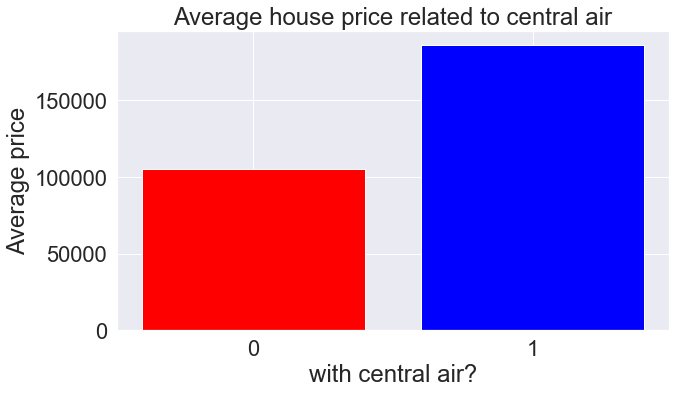

In [63]:
plt.figure(figsize=(10,6))

plt.subplot(1,1,1)
plt.bar(houseprices_df.groupby('central_air')['saleprice'].mean().index, houseprices_df.groupby('centralair')['saleprice'].mean(),
       color=('red','blue'))
plt.title('Average house price related to central air')
plt.ylabel('Average price')
plt.xlabel('with central air?')
plt.xticks([0,1])

plt.tight_layout()
plt.show()

In [58]:
#to plot all non-numeric columns, from sample
for index, column in objects:
    plt.subplot(11,4,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean(),
            color=('red','blue'))
    plt.title('Average saleprice related to {}.format(column)
              plt.ylabel('Average sale price')
              plt.xlabel(column)
              plt.xticks(rotation='vertical')
              
    plt.tight_layout()
    plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-58-c9750526a5a9>, line 5)

##### Build your initial model using these features and estimate the parameters using OLS.

In [67]:
features = ['overallqual', 'totalbsmtsf', 
                'firstflrsf', 'grlivarea', 'fullbath', 
                'garagecars', 'garagearea', 'yearbuilt', 
                'yearremodadd', 'masvnrtype', 'totrmsabvgrd', 
                'fireplaces', 'central_air']

###### running numerics only!
pulled 'masvnrtype','central_air',

In [69]:
houseprices_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
overallqual     1460 non-null int64
totalbsmtsf     1460 non-null int64
firstflrsf      1460 non-null int64
grlivarea       1460 non-null int64
fullbath        1460 non-null int64
garagecars      1460 non-null int64
garagearea      1460 non-null int64
yearbuilt       1460 non-null int64
yearremodadd    1460 non-null int64
masvnrtype      1452 non-null object
totrmsabvgrd    1460 non-null int64
fireplaces      1460 non-null int64
central_air     1460 non-null uint8
dtypes: int64(11), object(1), uint8(1)
memory usage: 138.4+ KB


In [73]:
# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set 
X = houseprices_df[['overallqual', 'totalbsmtsf', 
                'firstflrsf', 'grlivarea', 'fullbath', 
                'garagecars', 'garagearea', 'yearbuilt', 
                'yearremodadd', 'totrmsabvgrd', 
                'fireplaces']]

# create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.85454872e+04  2.07858228e+01  1.02027801e+01  4.62084052e+01
 -5.34603531e+03  8.64178412e+03  2.09383488e+01  2.65608379e+02
  3.32755045e+02  4.93999248e+02  9.83769343e+03]

Intercept: 
 -1246179.6830488362


In [74]:
import statsmodels.api as sm

# need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     461.9
Date:                Thu, 17 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:48:10   Log-Likelihood:                -17445.
No. Observations:                1460   AIC:                         3.491e+04
Df Residuals:                    1448   BIC:                         3.498e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.246e+06   1.28e+05     -9.710      0.000    -1.5e+06   -9.94e+05
overallqual   1.855e+04   1194.689     15.523      0.000    1.62e+04    2.09e+04
totalbsmtsf     20.7858      4.257      4.882      0.000      12.435      29.137
firstflrsf      10.2028      4.937      2.067      0.039       0.519      19.886
grlivarea       46.2084      4.295     10.758      0.000      37.783      54.634
fullbath     -5346.0353   2669.721     -2.002      0.045   -1.06e+04    -109.101
garagecars    8641.7841   3032.526      2.850      0.004    2693.170    1.46e+04
garagearea      20.9383     10.271      2.039      0.042       0.790      41.086
yearbuilt      265.6084     49.861      5.327      0.000     167.800     363.417
yearremodadd   332.7550     63.372      5.251      0.000     208.444     457.066
totrmsabvgrd   493.9992   1111.482      0.444      0.657   -1686.288    2674.286
fireplaces    9837.6934   1812.681      5.427      0.000    6281.932    1.34e+04
==============================================================================
Omnibus:                      461.607   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61152.471
Skew:                          -0.288   Prob(JB):                         0.00
Kurtosis:                      34.700   Cond. No.                     4.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### questions to review with Magda
1. how to make sample correlation list work
2. categorical variables - one hot coding? more than 2? rank?; something like neighborhood should be strongly correlated with sales price (location is everything)
3. sample multiple grid